In [1]:
# start with the libraries
# get environment information

import sys
print(sys.version)
print(sys.executable)

3.7.3 (default, Apr 24 2019, 15:29:51) [MSC v.1915 64 bit (AMD64)]
C:\ProgramData\Anaconda3\envs\timeseries\python.exe


In [2]:
# import the base libraries
# standard libraries
import pandas as pd
import numpy as np
import pyodbc
from pandas import Series, DataFrame
import os
import math
from itertools import cycle

# plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# get the datetime library for date & time calcs
from datetime import datetime, timedelta

# to visualize all of the columns in the dataframe
pd.pandas.set_option('display.max_columns', None)

In [3]:
# create the path for the file

myPath = os.path.join('N:', '\Bryan', 'Retention')

print(myPath)

os.chdir(myPath)

N:\Bryan\Retention


In [6]:
data = pd.read_csv('Maine_Mich_Canx.csv',index_col='CUST_END', parse_dates=True)

data.head()

,ME,MI
CUST_END,,
2009-01-31,2.0,25.0
2009-02-28,5.0,99.0
2009-03-31,7.0,273.0
2009-04-30,11.0,420.0
2009-05-31,14.0,506.0


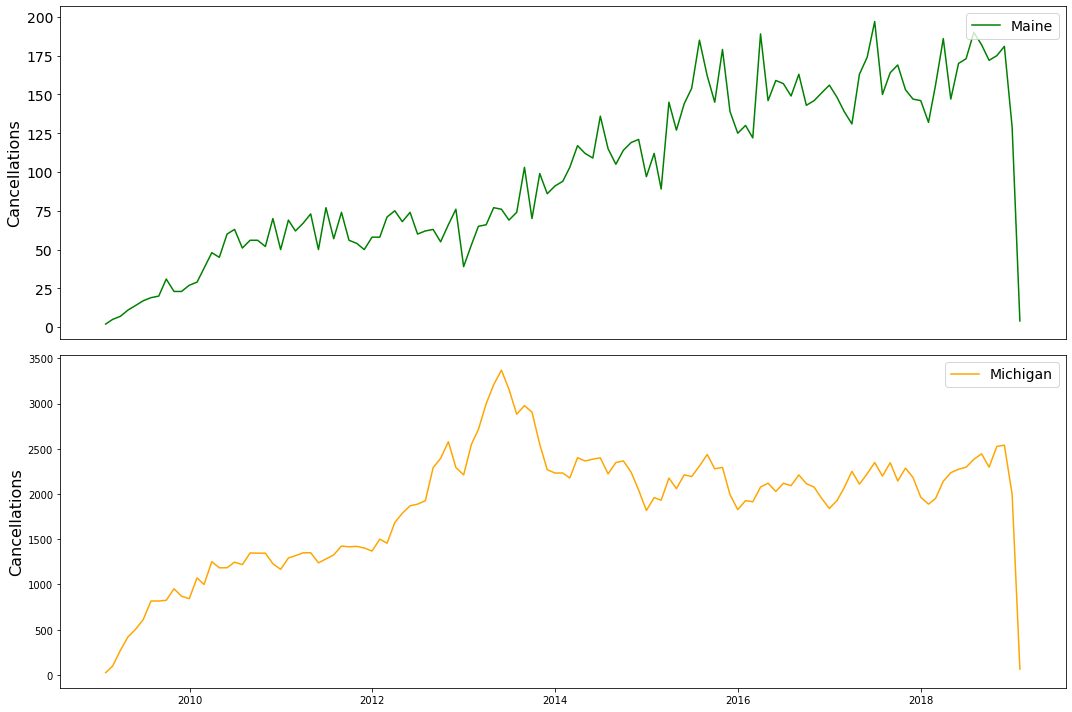

In [9]:
# make the nice plot

# set the figure size
fig = plt.figure(figsize = (15,10))

# the eries
ax1 = fig.add_subplot(211)
ax1.plot(data.index.values, data.ME, color = 'green', label = 'Maine')

# plot the legend for the first plot
ax1.legend(loc = 'upper right', fontsize = 14)

plt.ylabel('Cancellations', fontsize=16)
plt.setp(ax1.get_yticklabels(), fontsize=14) 

# Hide the top x axis
ax1.axes.get_xaxis().set_visible(False)

#######  NOW PLOT THE OTHER SERIES ON A SINGLE PLOT

# plot 212 is the MI series

# plot series
ax2 = fig.add_subplot(212)
ax2.plot(data.index.values, data.MI, color = 'orange', label = 'Michigan')

# plot the legend for the second plot
ax2.legend(loc = 'upper right', fontsize = 14)

# set the fontsize for the bottom plot
plt.ylabel('Cancellations', fontsize=16)
plt.setp(ax1.get_yticklabels(), fontsize=14) 
plt.setp(ax1.get_xticklabels(), fontsize=14)

plt.tight_layout()
plt.show()

In [10]:
# create augmented Dickey-Fuller test


from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [40]:
# import more libraries

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AR, ARResults
from statsmodels.tsa.arima_model import ARMA, ARIMA, ARMAResults, ARIMAResults
from statsmodels.tsa.statespace.sarimax import SARIMAX, SARIMAXResults

from statsmodels.tools.eval_measures import mse, rmse

from statsmodels.tsa.seasonal import seasonal_decompose

from pylab import rcParams

# Michigan

In [12]:
adf_test(data['MI'])

Augmented Dickey-Fuller Test: 
ADF test statistic       -1.207186
p-value                   0.670497
# lags used              12.000000
# observations          108.000000
critical value (1%)      -3.492401
critical value (5%)      -2.888697
critical value (10%)     -2.581255
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


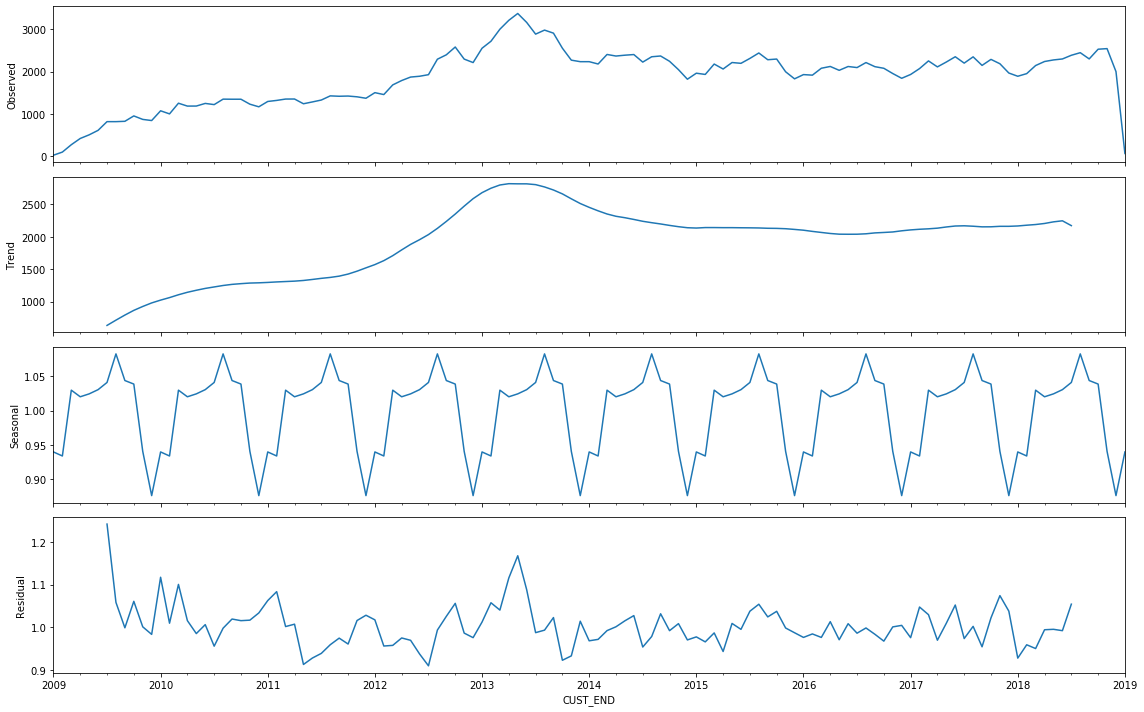

In [13]:
# decompose the series

result = seasonal_decompose(data['MI'], model = 'multiplicative')

rcParams['figure.figsize'] = 16,10
result.plot();

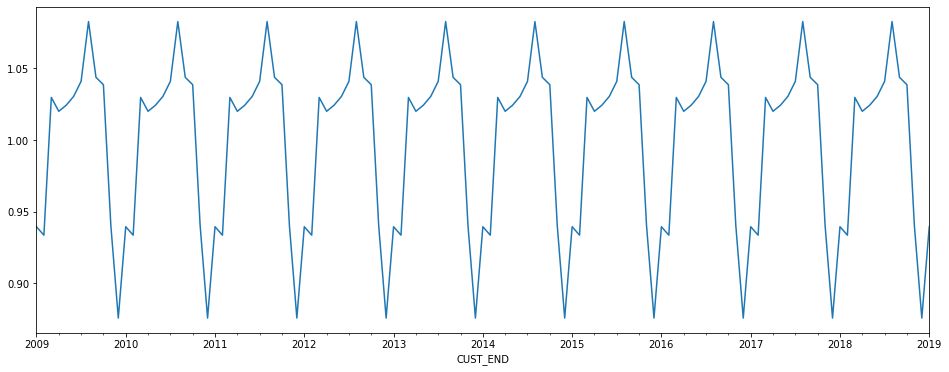

In [15]:
# blow up the seasonal for a better view

rcParams['figure.figsize'] = 16,6
ax = result.seasonal.plot();
ax.tick_params(axis='x', which='minor', bottom=True)
plt.show()

In [16]:
from statsmodels.tsa.statespace.tools import diff

# make a first difference
data['MIDiff_1'] = diff(data['MI'].iloc[0:-1], k_diff=1)
data['MIDiff_1'].head()

CUST_END
2009-01-31      NaN
2009-02-28     74.0
2009-03-31    174.0
2009-04-30    147.0
2009-05-31     86.0
Name: MIDiff_1, dtype: float64

In [17]:
# check the adf on the difference
adf_test(data['MIDiff_1'])

Augmented Dickey-Fuller Test: 
ADF test statistic       -2.316390
p-value                   0.166736
# lags used              11.000000
# observations          107.000000
critical value (1%)      -3.492996
critical value (5%)      -2.888955
critical value (10%)     -2.581393
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


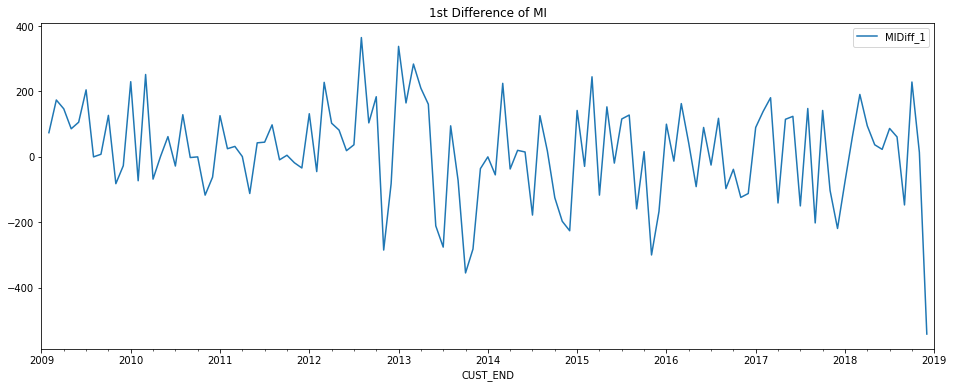

In [18]:
# get a plot of the 1st Diff
data['MIDiff_1'].plot(figsize=(16,6), legend=True, title='1st Difference of MI')

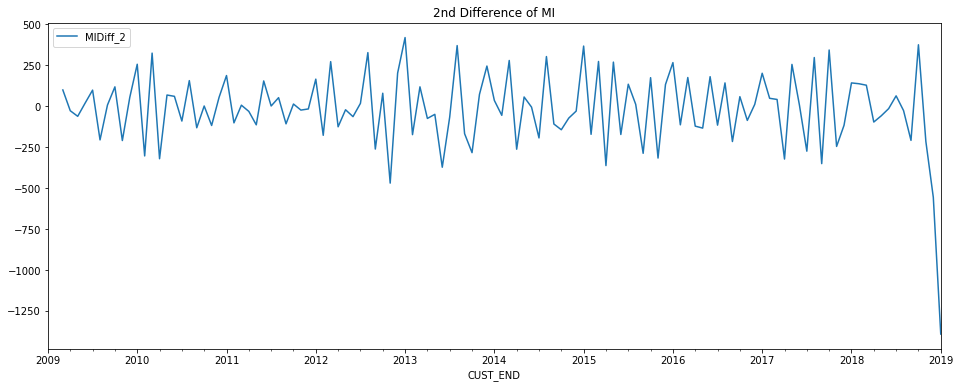

In [19]:
# make a second difference
data['MIDiff_2'] = diff(data['MI'], k_diff=2)

# get a plot of the 1st Diff
data['MIDiff_2'].plot(figsize=(16,6), legend=True, title='2nd Difference of MI')

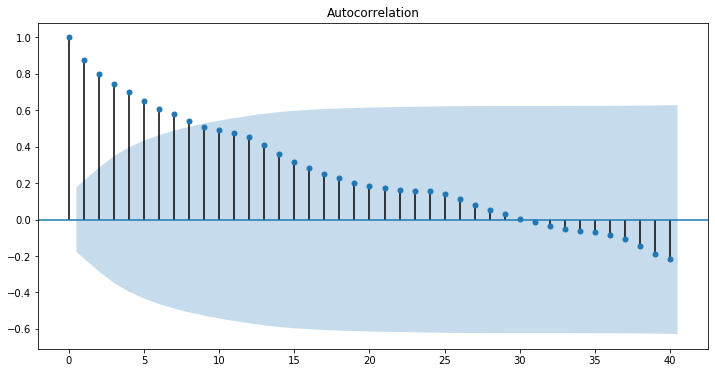

In [20]:
# get an acf plot

N, M = 12, 6
fig, ax = plt.subplots(figsize=(N, M))
plot_acf(data['MI'], lags=40, ax=ax)
plt.show()

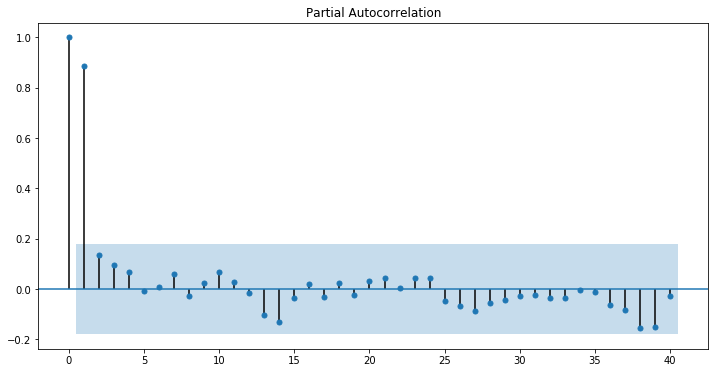

In [21]:
# get an pacf plot

N, M = 12, 6
fig, ax = plt.subplots(figsize=(N, M))
plot_pacf(data['MI'], lags=40, ax=ax)
plt.show()

# MI ARIMA Model

In [22]:
from pmdarima import auto_arima

In [23]:
# check what auto arima like for model
aa = auto_arima(data['MI'], start_p=0, start_q=0,
                max_p=5, max_q=2, seasonal=True,
                start_d=1, max_d=3, start_D=1, max_D=2, trace=True)

Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 0, 1); AIC=1650.600, BIC=1656.175, Fit time=0.096 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 0, 0, 1); AIC=1640.668, BIC=1649.030, Fit time=0.052 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 0, 0, 1); AIC=1643.284, BIC=1651.647, Fit time=0.131 seconds
Fit ARIMA: order=(2, 1, 0) seasonal_order=(0, 0, 0, 1); AIC=1642.656, BIC=1653.806, Fit time=0.166 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 0, 0, 1); AIC=1642.662, BIC=1653.812, Fit time=0.156 seconds


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:949: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Fit ARIMA: order=(2, 1, 1) seasonal_order=(0, 0, 0, 1); AIC=1644.449, BIC=1658.387, Fit time=0.259 seconds
Total fit time: 0.891 seconds


In [27]:
fcast = len(data) - 13
fcast

108

In [141]:
train = data.iloc[0:fcast]
test = data.iloc[fcast:-2]

In [142]:
print(test)

               ME      MI  MIDiff_1  MIDiff_2  MEDiff_1
CUST_END                                               
2018-01-31  132.0  1888.0     -76.0     143.0     -14.0
2018-02-28  156.0  1950.0      62.0     138.0      24.0
2018-03-31  186.0  2141.0     191.0     129.0      30.0
2018-04-30  147.0  2236.0      95.0     -96.0     -39.0
2018-05-31  170.0  2273.0      37.0     -58.0      23.0
2018-06-30  173.0  2296.0      23.0     -14.0       3.0
2018-07-31  190.0  2383.0      87.0      64.0      17.0
2018-08-31  182.0  2444.0      61.0     -26.0      -8.0
2018-09-30  172.0  2297.0    -147.0    -208.0     -10.0
2018-10-31  175.0  2526.0     229.0     376.0       3.0
2018-11-30  181.0  2540.0      14.0    -215.0       6.0


In [143]:
model = SARIMAX(train['MI'], order=(1,1,1), seasonal_order=(1,1,0,12), enforce_invertibility=True)

results = model.fit()

results.summary()

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:949: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                 MI   No. Observations:                  108
Model:             SARIMAX(1, 1, 1)x(1, 1, 0, 12)   Log Likelihood                -597.243
Date:                            Fri, 23 Aug 2019   AIC                           1202.485
Time:                                    15:45:30   BIC                           1212.701
Sample:                                01-31-2009   HQIC                          1206.613
                                     - 12-31-2017                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8158      0.182      4.491      0.000       0.460       1.172
ma.L1         -0.6679      0.235     -2.846      0.004      -1.128      -0.208
ar.S.L12      -0.4825      0.109     -4.429      0.000      -0.696      -0.269
sigma2      1.638e+04   2311.977      7.083      0.000    1.18e+04    2.09e+04
===================================================================================
Ljung-Box (Q):                       39.80   Jarque-Bera (JB):                 2.94
Prob(Q):                              0.48   Prob(JB):                         0.23
Heteroskedasticity (H):               1.63   Skew:                            -0.32
Prob(H) (two-sided):                  0.17   Kurtosis:                         3.57
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [144]:
# set up for backtesting

start = len(train)
end = len(train) + len(test) - 1

print(start)
print(end)

108
118


In [145]:
predictions = results.predict(start,end).rename('SARIMA Model')

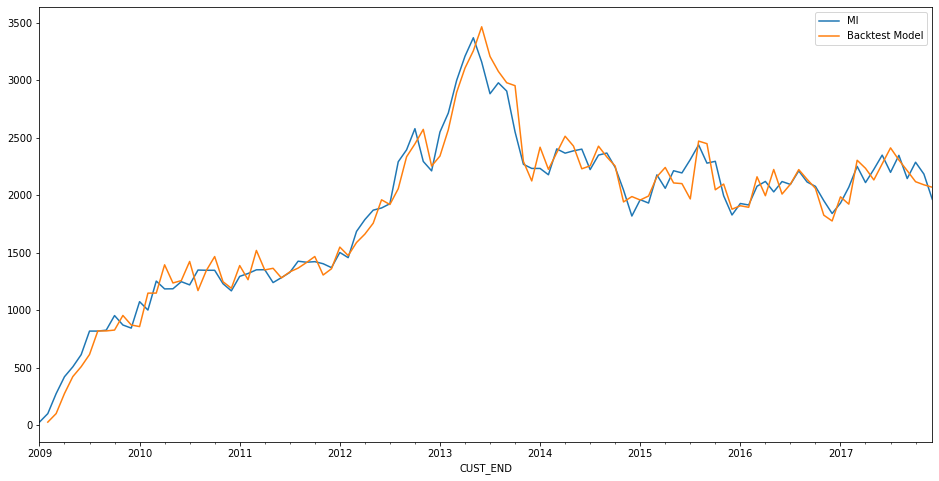

In [146]:
backtest = results.predict(start=1, end=start-1, typ='levels').rename('Backtest Model')


# make a plot of model fit
train['MI'].plot(figsize=(16,8), legend=True)
backtest.plot(legend=True);

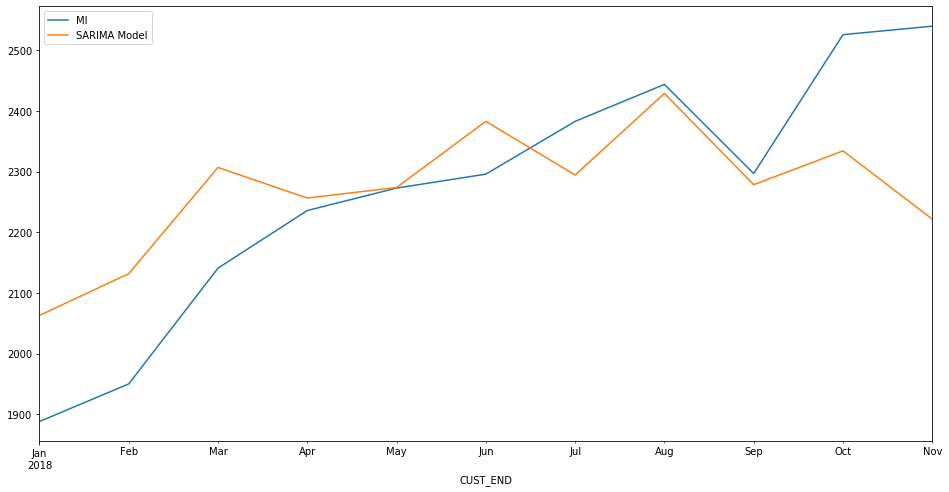

In [147]:
# make a plot of model fit

test['MI'].plot(figsize=(16,8), legend=True)
predictions.plot(legend=True);

In [148]:
error = rmse(test['MI'], predictions)
print(f'{error:.0f}', 'RMSE')

CancMean = test['MI'].mean()
print(f'{CancMean:.0f}', 'Mean of MI Canx')

percent = error/CancMean*100
print(f'{percent:.1f}', '% Error')

149 RMSE
2270 Mean of MI Canx
6.6 % Error


In [149]:
predictions_int = results.get_forecast(steps=11)
predictions_int.predicted_mean

2018-01-31    2062.947416
2018-02-28    2131.964831
2018-03-31    2307.022753
2018-04-30    2256.565167
2018-05-31    2273.988798
2018-06-30    2383.072344
2018-07-31    2294.604771
2018-08-31    2429.120256
2018-09-30    2278.595508
2018-10-31    2334.398974
2018-11-30    2221.804143
Freq: M, dtype: float64

In [150]:
predictions_int.conf_int()

,lower MI,upper MI
2018-01-31,1812.131676,2313.763156
2018-02-28,1750.124330,2513.805332
2018-03-31,1809.992579,2804.052928
2018-04-30,1652.745888,2860.384446
2018-05-31,1569.449557,2978.528039
2018-06-30,1582.850571,3183.294117
2018-07-31,1403.151613,3186.057928
2018-08-31,1450.480169,3407.760344
2018-09-30,1216.488925,3340.702091
2018-10-31,1192.266438,3476.531510


In [151]:
conf_df = pd.concat([test['MI'],predictions_int.predicted_mean, predictions_int.conf_int()], axis = 1)

conf_df.head()

,MI,0,lower MI,upper MI
2018-01-31,1888.0,2062.947416,1812.131676,2313.763156
2018-02-28,1950.0,2131.964831,1750.124330,2513.805332
2018-03-31,2141.0,2307.022753,1809.992579,2804.052928
2018-04-30,2236.0,2256.565167,1652.745888,2860.384446
2018-05-31,2273.0,2273.988798,1569.449557,2978.528039


In [152]:
conf_df = conf_df.rename(columns={0: 'Predictions', 'lower MI': 'Lower CI', 'upper MI': 'Upper CI'})
conf_df.head()

,MI,Predictions,Lower CI,Upper CI
2018-01-31,1888.0,2062.947416,1812.131676,2313.763156
2018-02-28,1950.0,2131.964831,1750.124330,2513.805332
2018-03-31,2141.0,2307.022753,1809.992579,2804.052928
2018-04-30,2236.0,2256.565167,1652.745888,2860.384446
2018-05-31,2273.0,2273.988798,1569.449557,2978.528039


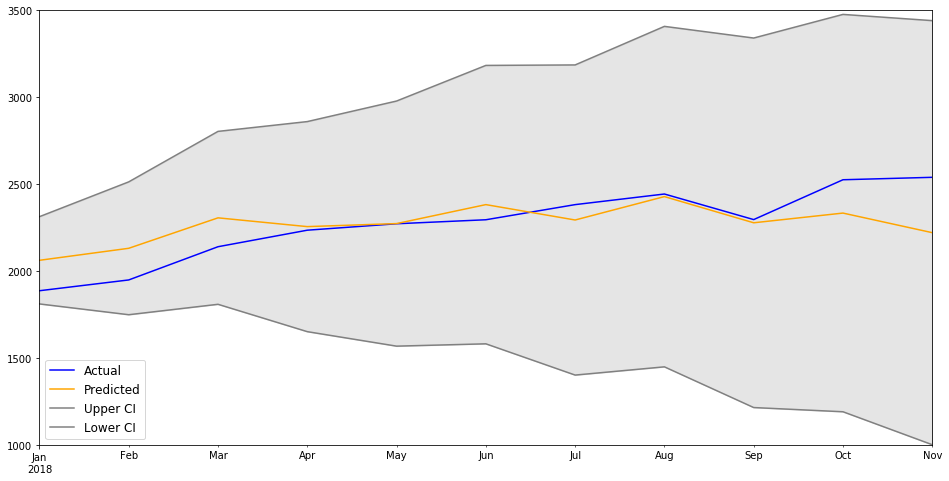

In [154]:
# make a plot of model fit
# color = 'skyblue'

fig = plt.figure(figsize = (16,8))
ax1 = fig.add_subplot(111)


x = conf_df.index.values


upper = conf_df['Upper CI']
lower = conf_df['Lower CI']

conf_df['MI'].plot(color = 'blue', label = 'Actual')
conf_df['Predictions'].plot(color = 'orange',label = 'Predicted' )
upper.plot(color = 'grey', label = 'Upper CI')
lower.plot(color = 'grey', label = 'Lower CI')

# plot the legend for the first plot
plt.legend(loc = 'lower left', fontsize = 12)


# fill between the conf intervals
plt.fill_between(x, lower, upper, color='grey', alpha='0.2')

plt.ylim(1000,3500)

plt.show()

# Maine

In [155]:
adf_test(data['ME'])

Augmented Dickey-Fuller Test: 
ADF test statistic       -2.005135
p-value                   0.284326
# lags used               1.000000
# observations          119.000000
critical value (1%)      -3.486535
critical value (5%)      -2.886151
critical value (10%)     -2.579896
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


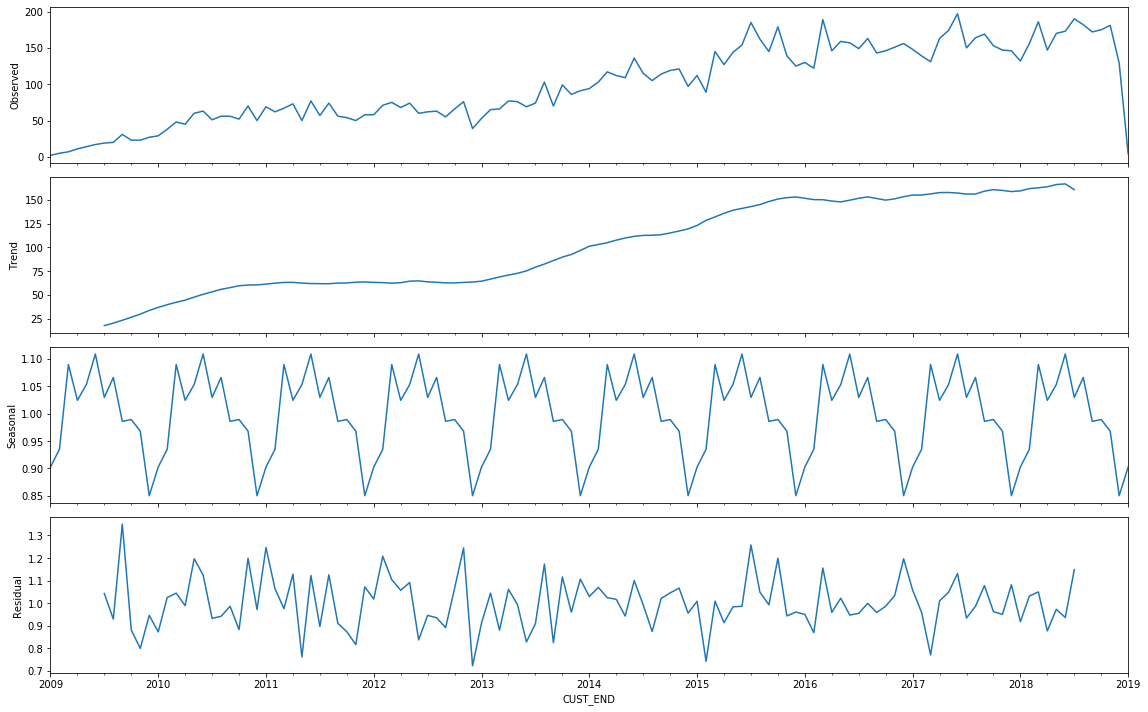

In [156]:
# decompose the series

result = seasonal_decompose(data['ME'], model = 'multiplicative')

rcParams['figure.figsize'] = 16,10
result.plot();

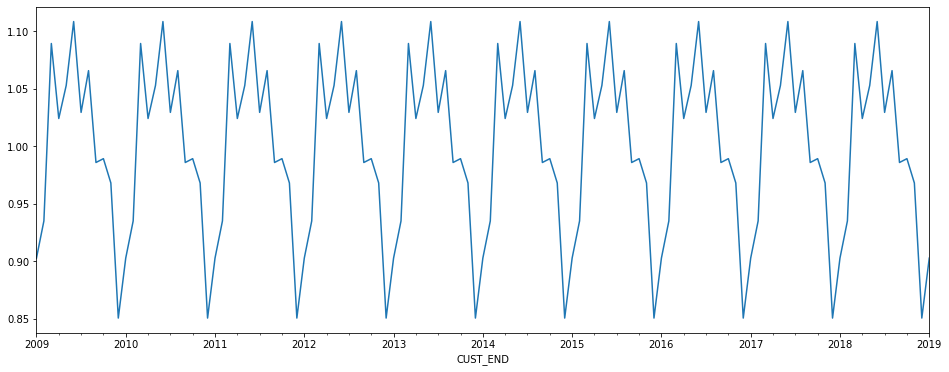

In [157]:
# blow up the seasonal for a better view

rcParams['figure.figsize'] = 16,6
ax = result.seasonal.plot();
ax.tick_params(axis='x', which='minor', bottom=True)
plt.show()

In [158]:
# make a first difference
data['MEDiff_1'] = diff(data['ME'].iloc[0:-1], k_diff=1)
data['MEDiff_1'].head()

CUST_END
2009-01-31    NaN
2009-02-28    3.0
2009-03-31    2.0
2009-04-30    4.0
2009-05-31    3.0
Name: MEDiff_1, dtype: float64

In [159]:
# check the adf on the difference
adf_test(data['MEDiff_1'])

Augmented Dickey-Fuller Test: 
ADF test statistic     -6.109765e+00
p-value                 9.394250e-08
# lags used             7.000000e+00
# observations          1.110000e+02
critical value (1%)    -3.490683e+00
critical value (5%)    -2.887952e+00
critical value (10%)   -2.580857e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


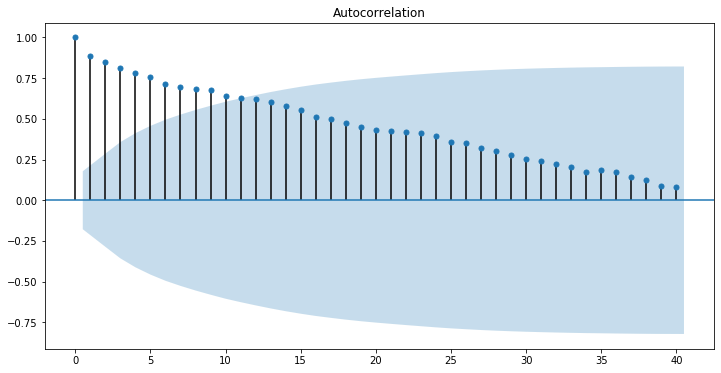

In [160]:
# get an acf plot

N, M = 12, 6
fig, ax = plt.subplots(figsize=(N, M))
plot_acf(data['ME'], lags=40, ax=ax)
plt.show()

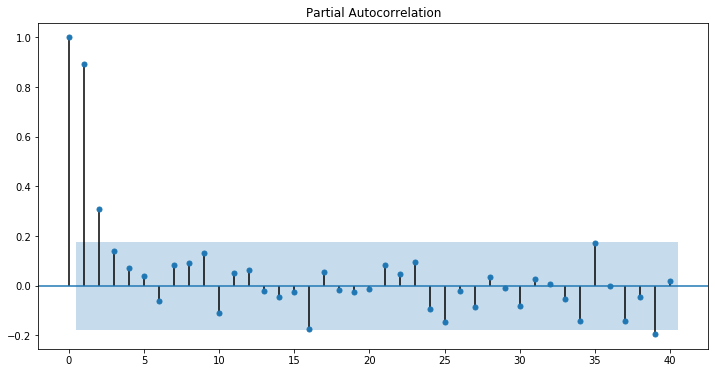

In [161]:
# get an pacf plot

N, M = 12, 6
fig, ax = plt.subplots(figsize=(N, M))
plot_pacf(data['ME'], lags=40, ax=ax)
plt.show()

In [162]:
train = data.iloc[0:fcast]
test = data.iloc[fcast:-2]

print(test)

               ME      MI  MIDiff_1  MIDiff_2  MEDiff_1
CUST_END                                               
2018-01-31  132.0  1888.0     -76.0     143.0     -14.0
2018-02-28  156.0  1950.0      62.0     138.0      24.0
2018-03-31  186.0  2141.0     191.0     129.0      30.0
2018-04-30  147.0  2236.0      95.0     -96.0     -39.0
2018-05-31  170.0  2273.0      37.0     -58.0      23.0
2018-06-30  173.0  2296.0      23.0     -14.0       3.0
2018-07-31  190.0  2383.0      87.0      64.0      17.0
2018-08-31  182.0  2444.0      61.0     -26.0      -8.0
2018-09-30  172.0  2297.0    -147.0    -208.0     -10.0
2018-10-31  175.0  2526.0     229.0     376.0       3.0
2018-11-30  181.0  2540.0      14.0    -215.0       6.0


In [195]:
model = SARIMAX(train['ME'], order=(1,1,0), seasonal_order=(1,1,0,12), enforce_invertibility=True)

results = model.fit()

results.summary()

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                 ME   No. Observations:                  108
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 12)   Log Likelihood                -410.857
Date:                            Fri, 23 Aug 2019   AIC                            827.715
Time:                                    15:55:47   BIC                            835.376
Sample:                                01-31-2009   HQIC                           830.811
                                     - 12-31-2017                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5342      0.086     -6.182      0.000      -0.704      -0.365
ar.S.L12      -0.5017      0.090     -5.589      0.000      -0.678      -0.326
sigma2       321.0618     36.423      8.815      0.000     249.674     392.450
===================================================================================
Ljung-Box (Q):                       56.53   Jarque-Bera (JB):                 9.66
Prob(Q):                              0.04   Prob(JB):                         0.01
Heteroskedasticity (H):               5.92   Skew:                            -0.43
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.30
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [196]:
# set up for backtesting

start = len(train)
end = len(train) + len(test) - 1

print(start)
print(end)

108
118


In [197]:
predictions = results.predict(start,end).rename('SARIMA Model')

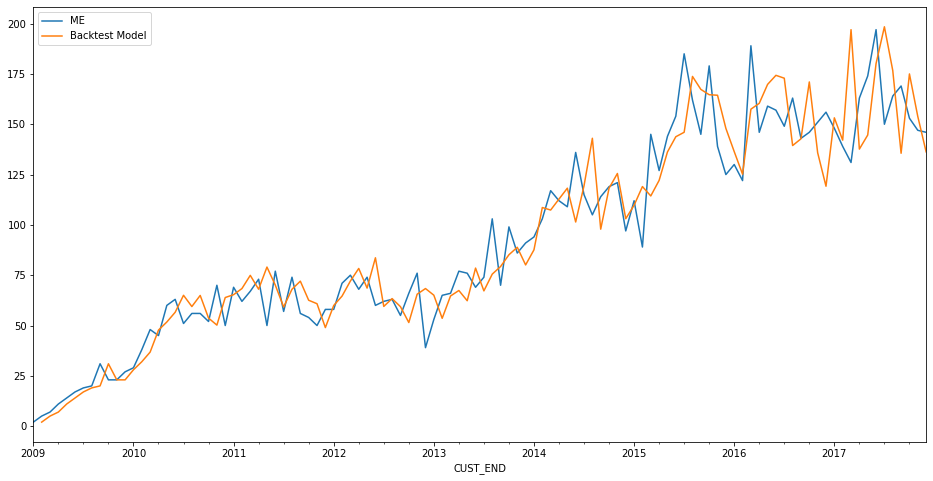

In [198]:
backtest = results.predict(start=1, end=start-1, typ='levels').rename('Backtest Model')


# make a plot of model fit
train['ME'].plot(figsize=(16,8), legend=True)
backtest.plot(legend=True);

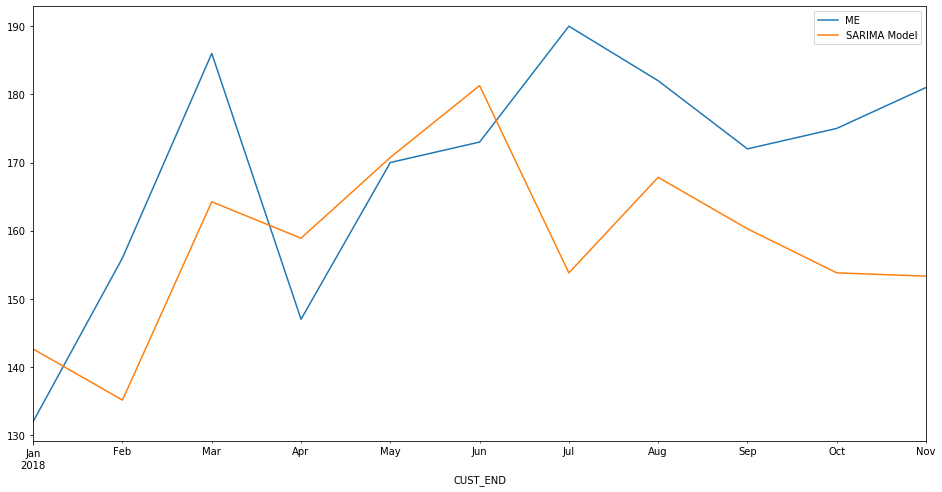

In [199]:
# make a plot of model fit

test['ME'].plot(figsize=(16,8), legend=True)
predictions.plot(legend=True);

In [200]:
error = rmse(test['ME'], predictions)
print(f'{error:.0f}', 'RMSE')

CancMean = test['ME'].mean()
print(f'{CancMean:.0f}', 'Mean of ME Canx')

percent = error/CancMean*100
print(f'{percent:.1f}', '% Error')

19 RMSE
169 Mean of ME Canx
11.4 % Error


In [201]:
predictions_int = results.get_forecast(steps=11)
predictions_int.predicted_mean

2018-01-31    142.635301
2018-02-28    135.144923
2018-03-31    164.234641
2018-04-30    158.894121
2018-05-31    170.743918
2018-06-30    181.283273
2018-07-31    153.806057
2018-08-31    167.829471
2018-09-30    160.274261
2018-10-31    153.813396
2018-11-30    153.328617
Freq: M, dtype: float64

In [202]:
predictions_int.conf_int()

,lower ME,upper ME
2018-01-31,107.516280,177.754321
2018-02-28,96.402347,173.887498
2018-03-31,117.363490,211.105793
2018-04-30,107.522260,210.265981
2018-05-31,114.090159,227.397677
2018-06-30,120.376796,242.189750
2018-07-31,88.639372,218.972742
2018-08-31,98.809282,236.849659
2018-09-30,87.531451,233.017072
2018-10-31,77.566761,230.060030


In [203]:
predictions

2018-01-31    142.635301
2018-02-28    135.144923
2018-03-31    164.234641
2018-04-30    158.894121
2018-05-31    170.743918
2018-06-30    181.283273
2018-07-31    153.806057
2018-08-31    167.829471
2018-09-30    160.274261
2018-10-31    153.813396
2018-11-30    153.328617
Freq: M, Name: SARIMA Model, dtype: float64

In [204]:
conf_df = pd.concat([test['ME'],predictions_int.predicted_mean, predictions_int.conf_int()], axis = 1)

conf_df.head()

,ME,0,lower ME,upper ME
2018-01-31,132.0,142.635301,107.516280,177.754321
2018-02-28,156.0,135.144923,96.402347,173.887498
2018-03-31,186.0,164.234641,117.363490,211.105793
2018-04-30,147.0,158.894121,107.522260,210.265981
2018-05-31,170.0,170.743918,114.090159,227.397677


In [205]:
conf_df = conf_df.rename(columns={0: 'Predictions', 'lower ME': 'Lower CI', 'upper ME': 'Upper CI'})
conf_df.head()

,ME,Predictions,Lower CI,Upper CI
2018-01-31,132.0,142.635301,107.516280,177.754321
2018-02-28,156.0,135.144923,96.402347,173.887498
2018-03-31,186.0,164.234641,117.363490,211.105793
2018-04-30,147.0,158.894121,107.522260,210.265981
2018-05-31,170.0,170.743918,114.090159,227.397677


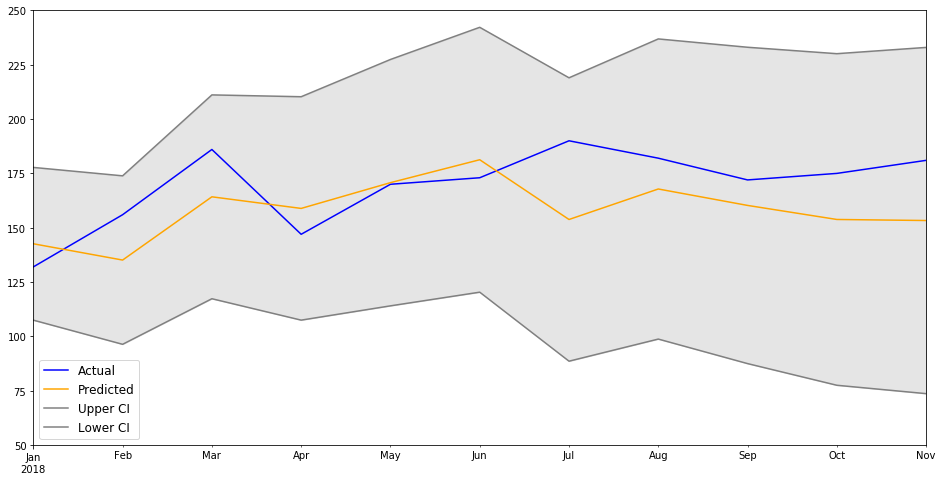

In [206]:
# make a plot of model fit
# color = 'skyblue'

fig = plt.figure(figsize = (16,8))
ax1 = fig.add_subplot(111)


x = conf_df.index.values


upper = conf_df['Upper CI']
lower = conf_df['Lower CI']

conf_df['ME'].plot(color = 'blue', label = 'Actual')
conf_df['Predictions'].plot(color = 'orange',label = 'Predicted' )
upper.plot(color = 'grey', label = 'Upper CI')
lower.plot(color = 'grey', label = 'Lower CI')

# plot the legend for the first plot
plt.legend(loc = 'lower left', fontsize = 12)


# fill between the conf intervals
plt.fill_between(x, lower, upper, color='grey', alpha='0.2')

plt.ylim(50,250)

plt.show()